# Classificazione video con mediapipe


In [1]:
from app.dataset.dataset import Dataset
from app.plotter.frames_plotter import plot_frames
from wlasl_mediapipe.app.dtw.dtw import classify, pretty_print
from wlasl_mediapipe.app.utils.mp.helper.hand_landmark_drawer import draw_landmarks_on_image
from wlasl_mediapipe.launcher import Launcher

from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import mediapipe as mp
import matplotlib.pyplot as plt


2025-02-25 18:25:39.488191: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-25 18:25:39.488448: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-25 18:25:39.490787: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-25 18:25:39.515596: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-25 18:25:40.261052: W tensorflow/compiler/tf2tensorrt/utils/py_uti

## Import del dataset

In [2]:
launcher = Launcher()
data = launcher.load_data()
glosses = launcher.load_glosses(filtered=False)[:10]

## Video di esempio
Plot di due frame di due diversi video in cui viene mostrato come mediapipe estrae i keypoint relativi al volto e alla posa dei soggetti

E0000 00:00:1740504341.940663  410745 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1740504341.940721  410745 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1740504341.940726  410745 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1740504341.940731  410745 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1740504341.940736  410745 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1740504341.94

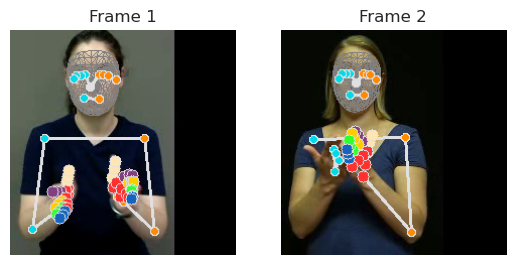

In [3]:
dataset = Dataset("data/WLASL_v0.3.json")

mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils
detector = mp_holistic.Holistic(static_image_mode=True,
                                model_complexity=2,
                                min_detection_confidence=0.5,
                                min_tracking_confidence=0.5,
                                refine_face_landmarks=True,
                                )

image_1 = dataset.videos[0].get_frames()[10]
image_2 = dataset.videos[1].get_frames()[10]

annotated_image_1 = draw_landmarks_on_image(image_1, detector.process(image_1))
annotated_image_2 = draw_landmarks_on_image(image_2, detector.process(image_2))
plot_frames([annotated_image_1, annotated_image_2])


## Split training e test set
Durante il caricamento dei video, vengono automaticamente estratti o caricati da disco i keypoint relativi alle mani dei soggetti e viene calcolato l'arcocoseno tra i vari keypoint estratti per ogni mano. Elaborando in questo modo i keypoint si evitano problemi riguardanti la scala delle immagini, e la posizione delle mani nel frame.

In [4]:
training_videos = launcher.get_train_videos(dataset=data, glosses=glosses)
test_videos = launcher.get_test_videos(dataset=data, glosses=glosses)

## Classificazione risultati
La classificazione viene effettuata con DTW andando a confrontare ogni video di test con tutti i video del training set. Al video viene assegnata la label pari al video del training set con distanza minima. Vengono però salvate anche le distanze con ogni altra parola del training set, creando una classifica delle parole più simili.

In [5]:
results = classify(test_videos=test_videos, train_videos=training_videos, augment=0, topN=5)

100%|██████████| 10/10 [01:42<00:00, 10.24s/it]


## Stampa dei risultati

In [6]:
pretty_print(results, "top1-res-notebook.log", 1)

Top1 score:
Real Word    Classified Words
-----------  ----------------------------------
book         [('book', 15396.438622058977)]
book         [('before', 10941.098788632464)]
book         [('book', 17688.447524368385)]
book         [('book', 2424.474392682466)]
drink        [('drink', 3595.3617042550036)]
drink        [('drink', 6476.124687152994)]
drink        [('drink', 7379.600056815788)]
drink        [('drink', 15065.943743019234)]
computer     [('chair', 20483.962390956847)]
computer     [('drink', 6000.198847755066)]
computer     [('computer', 14334.507553576372)]
computer     [('computer', 12481.704473903765)]
computer     [('book', 10883.614309223114)]
before       [('cousin', 4872.539279197935)]
before       [('before', 17003.76690564434)]
before       [('before', 10867.155485573134)]
before       [('before', 3285.9440937360664)]
chair        [('chair', 9954.988759511634)]
chair        [('chair', 18930.06040827674)]
chair        [('chair', 19550.7092897049)]
go           

In [7]:
pretty_print(results, "top5-res-notebook.log", 5)

Top5 score:
Real Word    Classified Words
-----------  ----------------------------------------------------------------------------------------------------------------------------------------------------------------
book         [('book', 15396.438622058977), ('clothes', 17072.794073511155), ('drink', 17289.961257300205), ('computer', 19001.520222238254), ('before', 17077.149201198612)]
book         [('before', 10941.098788632464), ('book', 11370.995625012467), ('drink', 13921.375947216668), ('clothes', 14177.46630676748), ('computer', 15747.317180423157)]
book         [('book', 17688.447524368385), ('clothes', 19689.939063655234), ('drink', 20749.837051305927), ('computer', 24216.935955779925), ('before', 21646.813362985296)]
book         [('book', 2424.474392682466), ('clothes', 10329.428766687997), ('go', 13508.985434015161), ('cousin', 14731.985259802677), ('drink', 16125.00984540833)]
drink        [('drink', 3595.3617042550036), ('cousin', 6731.120474285404), ('candy', 10194.49975

In [8]:
Y_pred = [result[0][0] for result in results.values()]
Y_test = [result.video.gloss for result in results]

## Stampa della confusion matrix
Dalla confusion matrix si osseva il fatto che il classificatore ha maggiori difficoltà nel classificare le parole "clothes" e "candy", questo è dovuto al fatto che TODO

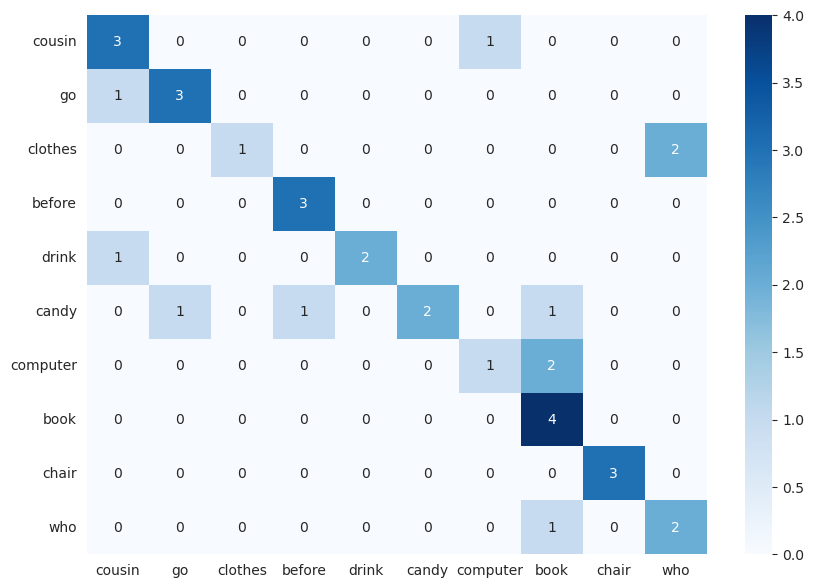

In [11]:
# TODO: markdown sopra
def plot_confusion_matrix(Y_test, Y_pred):
    """Plot confusion matrix."""
    cfm = confusion_matrix(Y_test, Y_pred)
    df_cfm = pd.DataFrame(cfm, index=list(set(Y_test)), columns=list(set(Y_test)))

    plt.figure(figsize=(10, 7))
    cfm_plot = sns.heatmap(df_cfm, annot=True, cmap="Blues", fmt="d")
    cfm_plot.figure.savefig("cfm/cfm.png")
    plt.show()


plot_confusion_matrix(Y_test, Y_pred)
